In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# Define strategies
def one_choice(m):
    return random.randint(0, m - 1)

def two_choice(m, loads):
    choices = random.sample(range(m), 2)
    return choices[0] if loads[choices[0]] <= loads[choices[1]] else choices[1]

def one_plus_beta_choice(m, loads, beta=0.5):
    if random.random() < beta:
        return one_choice(m)
    else:
        return two_choice(m, loads)

def partial_information_choice(m, loads):
    candidates = random.sample(range(m), 2)
    median_load = np.median(loads)
    load_above_median = [loads[c] > median_load for c in candidates]
    if load_above_median[0] != load_above_median[1]:
        return candidates[0] if not load_above_median[0] else candidates[1]
    top_75 = np.percentile(loads, 75)
    in_top_75 = [loads[c] > top_75 for c in candidates]
    if in_top_75[0] != in_top_75[1]:
        return candidates[0] if not in_top_75[0] else candidates[1]
    return random.choice(candidates)

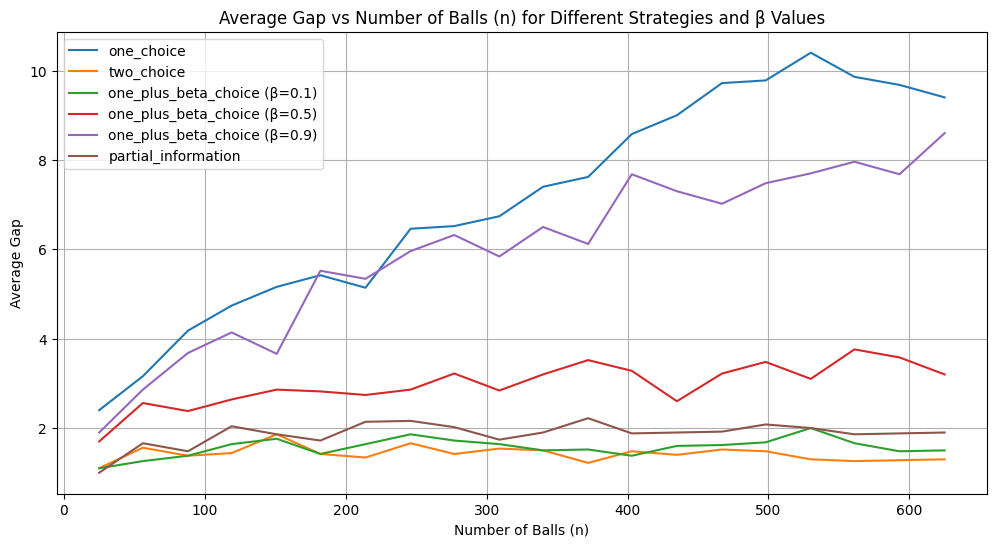

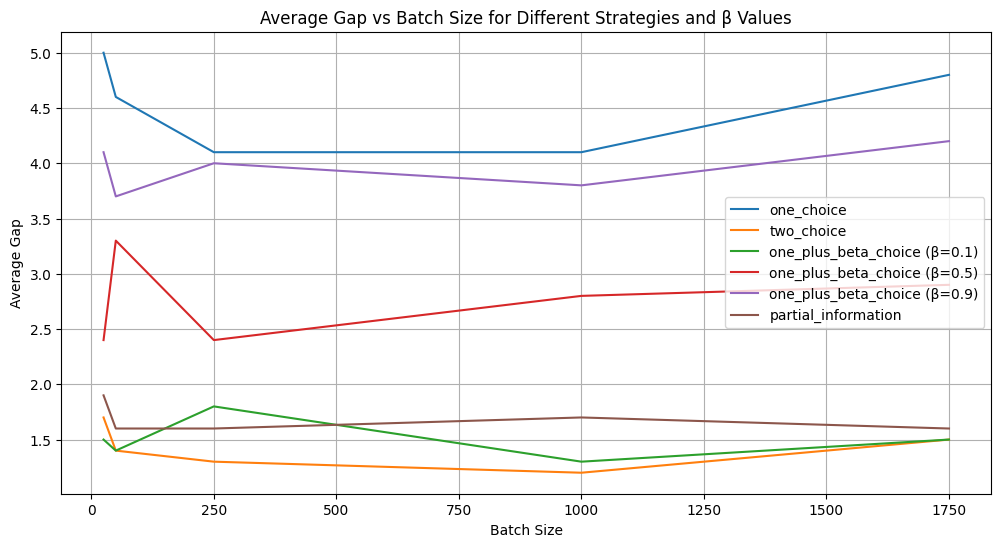

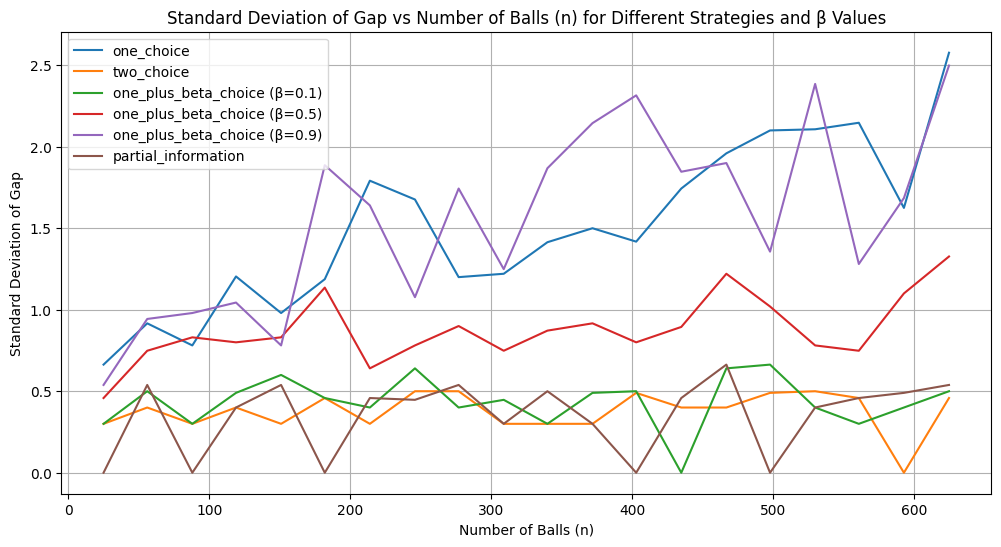

In [ ]:
# Simulation function
def allocation_simulation(m, n, strategy, beta=0.5, batch_size=1, partial_info=False):
    loads = np.zeros(m, dtype=int)
    for i in range(0, n, batch_size):
        batch_end = min(i + batch_size, n)
        for _ in range(i, batch_end):
            if strategy == 'one_choice':
                bin_choice = one_choice(m)
            elif strategy == 'two_choice':
                bin_choice = two_choice(m, loads)
            elif strategy == 'one_plus_beta_choice':
                bin_choice = one_plus_beta_choice(m, loads, beta)
            elif strategy == 'partial_information':
                bin_choice = partial_information_choice(m, loads)
            loads[bin_choice] += 1
    max_load = np.max(loads)
    gap = max_load - n / m
    return gap, loads

# Run experiments function
def run_experiments(m, n, strategy, beta=0.5, batch_size=1, T=10):
    gaps = []
    for _ in range(T):
        gap, _ = allocation_simulation(m, n, strategy, beta, batch_size, strategy == 'partial_information')
        gaps.append(gap)
    avg_gap = np.mean(gaps)
    std_dev_gap = np.std(gaps)
    return avg_gap, std_dev_gap

# Parameters
m = 25
n_values = np.linspace(m, m ** 2, num=20, dtype=int)
betas = [0.1, 0.5, 0.9]
T = 10
strategies = ['one_choice', 'two_choice', 'one_plus_beta_choice', 'partial_information']

# Data collection for different strategies
results = {strategy: {beta: {'n': [], 'avg_gap': [], 'std_dev_gap': []} for beta in ([0] if strategy != 'one_plus_beta_choice' else betas)} for strategy in strategies}

for n in n_values:
    for strategy in strategies:
        if strategy == 'one_plus_beta_choice':
            for beta in betas:
                avg_gap, std_dev_gap = run_experiments(m, n, strategy, beta=beta, T=T)
                results[strategy][beta]['n'].append(n)
                results[strategy][beta]['avg_gap'].append(avg_gap)
                results[strategy][beta]['std_dev_gap'].append(std_dev_gap)
        else:
            avg_gap, std_dev_gap = run_experiments(m, n, strategy, T=T)
            results[strategy][0]['n'].append(n)
            results[strategy][0]['avg_gap'].append(avg_gap)
            results[strategy][0]['std_dev_gap'].append(std_dev_gap)

# Plotting for different strategies
plt.figure(figsize=(12, 6))
for strategy in strategies:
    for beta, data in results[strategy].items():
        label = f"{strategy} (β={beta})" if strategy == 'one_plus_beta_choice' else strategy
        plt.plot(data['n'], data['avg_gap'], label=label)
plt.title("Average Gap vs Number of Balls (n) for Different Strategies and β Values")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

# Batch Mode Experiments for different strategies
n_fixed = 100  # Fixed n value for batch experiment
batch_sizes = [m, 2 * m, 10 * m, 40 * m, 70 * m]

batch_results = {strategy: {beta: {'batch_size': [], 'avg_gap': [], 'std_dev_gap': []} for beta in ([0] if strategy != 'one_plus_beta_choice' else betas)} for strategy in strategies}

for batch_size in batch_sizes:
    for strategy in strategies:
        if strategy == 'one_plus_beta_choice':
            for beta in betas:
                avg_gap, std_dev_gap = run_experiments(m, n_fixed, strategy, beta=beta, batch_size=batch_size, T=T)
                batch_results[strategy][beta]['batch_size'].append(batch_size)
                batch_results[strategy][beta]['avg_gap'].append(avg_gap)
                batch_results[strategy][beta]['std_dev_gap'].append(std_dev_gap)
        else:
            avg_gap, std_dev_gap = run_experiments(m, n_fixed, strategy, batch_size=batch_size, T=T)
            batch_results[strategy][0]['batch_size'].append(batch_size)
            batch_results[strategy][0]['avg_gap'].append(avg_gap)
            batch_results[strategy][0]['std_dev_gap'].append(std_dev_gap)

# Plot Batch results
plt.figure(figsize=(12, 6))
for strategy, beta_data in batch_results.items():
    for beta, data in beta_data.items():
        label = f"{strategy} (β={beta})" if strategy == 'one_plus_beta_choice' else strategy
        plt.plot(data['batch_size'], data['avg_gap'], label=label)
plt.title("Average Gap vs Batch Size for Different Strategies and β Values")
plt.xlabel("Batch Size")
plt.ylabel("Average Gap")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Standard Deviation of Gap as a function of n
plt.figure(figsize=(12, 6))
for strategy in strategies:
    for beta, data in results[strategy].items():
        label = f"{strategy} (β={beta})" if strategy == 'one_plus_beta_choice' else strategy
        plt.plot(data['n'], data['std_dev_gap'], label=label)
plt.title("Standard Deviation of Gap vs Number of Balls (n) for Different Strategies and β Values")
plt.xlabel("Number of Balls (n)")
plt.ylabel("Standard Deviation of Gap")
plt.legend()
plt.grid(True)
plt.show()
